In [19]:
import io
import requests
import os
import datetime
import urllib.request

import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from shapely.geometry import Point
from shapely.ops import cascaded_union, unary_union

In [2]:
# Load cdec reservoirs
data_dir = "../data"
files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if "cdec" in x]
df = pd.read_csv(files[0])

# Make a gdf
lats = df.Latitude
longs = df.Longitude
crs = {"init":"epsg:4326"}
geom = [Point(xy) for xy in zip(longs,lats)]
gdf = gp.GeoDataFrame(df, crs = crs, geometry = geom)

# Save
if not os.path.exists("../shape/cdec_reservoirs.shp"):
    gdf.to_file("../shape/cdec_reservoirs.shp")
else:
    pass

In [3]:
# Read the HU4s and merge
s1 = gp.read_file("../shape/1804_4.shp")
s2 = gp.read_file("../shape/1803_4.shp")
s3 = gp.read_file("../shape/1802_4.shp")

ssjt = gp.GeoDataFrame(pd.concat([s1,s2,s3], ignore_index=True))
ssjt.crs = crs

# Read cv
cv = gp.read_file("../shape/cv.shp")

# Make small buffer around cv
buffered_cv = cv.buffer(0.005)
buf = gp.GeoDataFrame(gp.GeoSeries(buffered_cv))
buf = buf.rename(columns={0:'geometry'}).set_geometry('geometry')
buf.crs = crs

# Filter
within_cv = gp.sjoin(gdf, buf, how='inner', op='intersects')
within_ssjt = gp.sjoin(gdf, ssjt, how='inner', op='intersects')

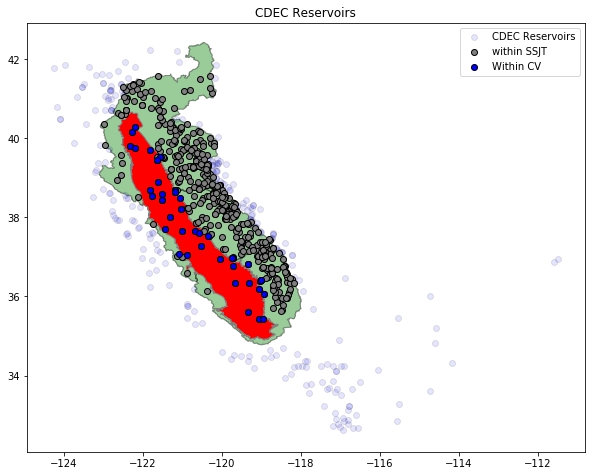

In [4]:
fig, ax = plt.subplots(figsize = (10, 10))

plt.title("CDEC Reservoirs")
ssjt.plot(ax = ax, color = "green", alpha = 0.4, edgecolor = "black",label =  "SSJT HU4 watershed")
cv.plot(ax = ax, color = "red", edgecolor = "gray", label = "CV alluvial fill")
gdf.plot(ax = ax, color = "blue", alpha = 0.1, edgecolor='black', label = "CDEC Reservoirs")
within_ssjt.plot(ax = ax, color = "gray", alpha = 1, edgecolor='black', label = "within SSJT")
within_cv.plot(ax = ax, color = "blue", alpha = 1, edgecolor='black', label = "Within CV")
ax.legend()

plt.show()

In [5]:
within_ssjt.head()

,Station,ID,Elev (feet),Latitude,Longitude,County,River Basin,Unnamed: 7,geometry,index_right,...,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC4,Shape_Leng,Shape_Area
0,ABBEY,ABY,5650,39.955000,-120.538000,PLUMAS,FEATHER R,NaN,POINT (-120.538 39.955),2,...,None,None,2018/05/15,0.0,17794831.69,72013.19,"CA,OR",1802,23.647202,7.598824
1,ADIN MOUNTAIN,ADI,6200,41.237000,-120.793000,MODOC,PIT R,NaN,POINT (-120.793 41.23699999999999),2,...,None,None,2018/05/15,0.0,17794831.69,72013.19,"CA,OR",1802,23.647202,7.598824
2,ADIN RS,ADN,4195,41.194000,-120.944000,MODOC,PIT R,NaN,POINT (-120.944 41.194),2,...,None,None,2018/05/15,0.0,17794831.69,72013.19,"CA,OR",1802,23.647202,7.598824
4,ALPHA,APH,7600,38.804138,-120.215645,EL DORADO,AMERICAN R,NaN,POINT (-120.215645 38.804138),2,...,None,None,2018/05/15,0.0,17794831.69,72013.19,"CA,OR",1802,23.647202,7.598824
6,ALTURAS RS,ALT,4400,41.500000,-120.550000,MODOC,PIT R,NaN,POINT (-120.55 41.5),2,...,None,None,2018/05/15,0.0,17794831.69,72013.19,"CA,OR",1802,23.647202,7.598824


In [12]:
# Download Storage (SensorNums = 15) data by query str:

start = datetime.datetime(2001, 1, 1)
end = datetime.datetime(2019, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

ssjt_data = {}

for i in within_ssjt.ID:
    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=15&dur_code=M&Start=2001-01-01&End=2018-12-01".format(i)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    
    if df.empty:
        pass
    else:
        ssjt_data[i] = df

cv_data={}

for i in within_cv.ID:
    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=15&dur_code=M&Start=2001-01-01&End=2018-12-01".format(i)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    
    if df.empty:
        pass
    else:
        cv_data[i] = df

    

In [16]:
ssjt_s = []
ssjt_df = {}

for k,v in ssjt_data.items():
    ssjt_s.append(pd.to_numeric(data[k].VALUE, errors = "coerce"))
    ssjt_df[k] = ssjt_data[k].VALUE

cv_s = []
cv_df = {}
for k,v in cv_data.items():
    cv_s.append(pd.to_numeric(data[k].VALUE, errors = "coerce"))
    ssjt_df[k] = data[k].VALUE

ssjt_ts = np.nansum(np.column_stack(ssjt_s), axis = 1)
cv_ts = np.nansum(np.column_stack(cv_s), axis = 1)

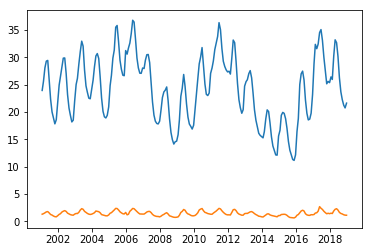

In [17]:
plt.plot(dt_idx,ssjt_ts*1.23348e-6)
plt.plot(dt_idx,cv_ts*1.23348e-6)

In [8]:
# Calculate monthly means
means = pd.DataFrame.from_dict(rs_df).mean(axis = 0)
m = pd.DataFrame(means* 1.23348e-6, index = means.index)
m.columns = ["storage"] 

In [9]:
avg_stage = within_ssjt.merge(m, left_on = "ID", right_index = True)

In [84]:
# Extract some data for the plotting 
max_val = avg_stage['storage'].max()
med_val = avg_stage['storage'].median()
min_val = avg_stage['storage'].min()

f1 = avg_stage[avg_stage['storage'] == max_val]
f2 = avg_stage[avg_stage['storage'] == med_val]
f3 = avg_stage[avg_stage['storage'] == min_val]

p1, p2, p3, = np.percentile(avg_stage['storage'],33), np.percentile(avg_stage['storage'],85), np.percentile(avg_stage['storage'],95)

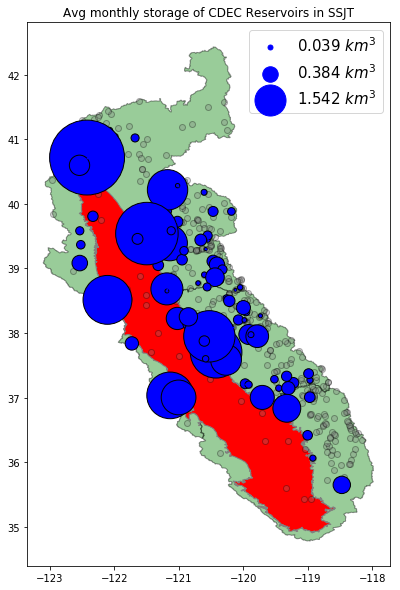

In [85]:
fig, ax = plt.subplots(figsize = (7, 10))

plt.title("Avg monthly storage of CDEC Reservoirs in SSJT")
ssjt.plot(ax = ax, color = "green", alpha = 0.4, edgecolor = "black",label =  "SSJT HU4 watershed")
cv.plot(ax = ax, color = "red", edgecolor = "gray", label = "CV alluvial fill")
within_ssjt.plot(ax = ax, color = "gray", alpha = 0.3, edgecolor='black')
avg_stage.plot(ax = ax, markersize = avg_stage.storage*1500, color = "blue", alpha = 1, edgecolor='black')

avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p1, label = "{} $km^3$".format(round(p1,3)))
avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p2, label = "{} $km^3$".format(round(p2,3)))
avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p3, label = "{} $km^3$".format(round(p3,3)))

plt.legend(markerscale = 50, prop={'size': 15})

plt.savefig("../figs/reservoir_storage.png")

plt.show()

In [86]:
rivers = gp.read_file("../shape/rivers_CVW.shp")
reaches = gp.read_file("../c2vsim/C2VSimFG_StreamReaches.shp").dropna()
reaches = reaches.to_crs({'init': 'epsg:4326'})

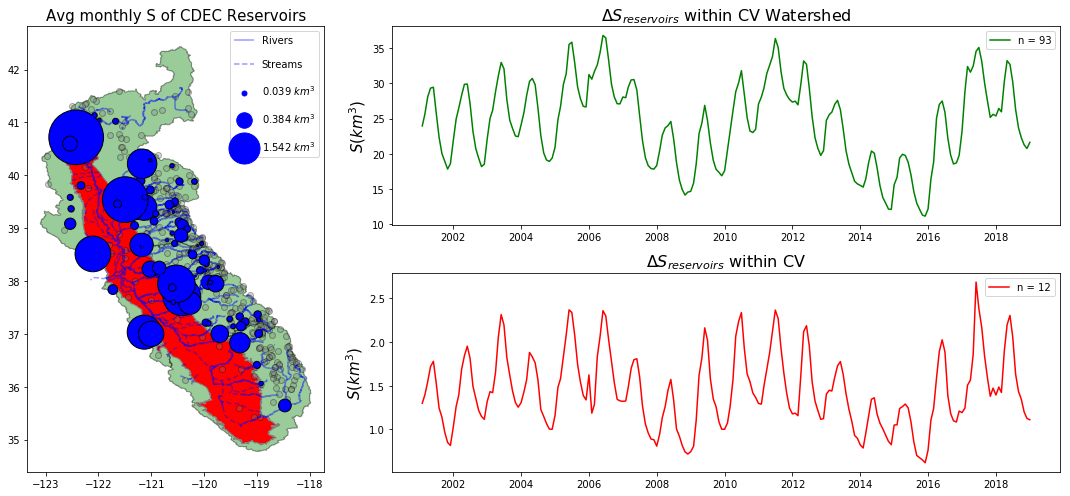

In [102]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

ax = plt.subplot(G[:, 0])
ax.set_title("Avg monthly S of CDEC Reservoirs", size = 15)
rivers.plot(ax = ax, color = "blue", alpha = 0.4,label =  "Rivers")
reaches.plot(ax = ax, color = "blue", linestyle =  "--", alpha = 0.4,label =  "Streams")

ssjt.plot(ax = ax, color = "green", alpha = 0.4, edgecolor = "black",label =  "SSJT HU4 watershed")
cv.plot(ax = ax, color = "red", edgecolor = "gray", label = "CV alluvial fill")
within_ssjt.plot(ax = ax, color = "gray", alpha = 0.3, edgecolor='black')
avg_stage.plot(ax = ax, markersize = avg_stage.storage*800, color = "blue", alpha = 1, edgecolor='black')

avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p1, label = "{} $km^3$".format(round(p1,3)))
avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p2, label = "{} $km^3$".format(round(p2,3)))
avg_stage.plot(ax = ax, marker = ".", c = "blue", markersize = p3, label = "{} $km^3$".format(round(p3,3)))

ax.legend(markerscale = 50, prop={'size': 10},labelspacing=1.4) # loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True,

a2 = plt.subplot(G[0, 1:])
a2.set_title("$\Delta S_{reservoirs}$ within CV Watershed", size = 16)
a2.plot(dt_idx,ssjt_ts*1.23348e-6, color = "green", label = "n = {}".format(str(len(ssjt_s))))
a2.legend()
a2.set_ylabel("$S (km^3)$", size = 15)

a3 = plt.subplot(G[1, 1:])
a3.set_title("$\Delta S_{reservoirs}$ within CV ", size = 16)
a3.plot(dt_idx,cv_ts*1.23348e-6, color ="red", label = "n = {}".format(str(len(cv_s))))
a3.legend()
a3.set_ylabel("$S (km^3)$", size = 15)

plt.tight_layout()
plt.show()


In [ ]:

a0.set_title("Total Reservoir Storage ")
a0.plot(dt_idx,total_s*1.23348e-6, label = "Total Reservoir Storage (USGS)", color = "blue", linewidth = 2.0)
a0.set_ylabel("storage $km^3$")

plt.savefig("../figs/monthly_res_storage_timeseries.png")

plt.show()

In [ ]:
out = pd.DataFrame([total_s*1.23348e-6]).T
out.columns = ['storage_km3']
out.index = dt_idx
out.head()

In [347]:
out.to_csv("../data/reservoir_storage_ssjt.csv")